calories                float64
protein                 float64
carbohydrate            float64
sugar                   float64
fat                     float64
sodium                  float64
category_encoded          int64
suitable_for_disease      int64
sugar_to_carb_ratio     float64
fat_to_calorie_ratio    float64
dtype: object
[(0, 'Balanced'), (1, 'Low Fat'), (2, 'Low Sodium'), (3, 'Low Sugar')]

--- Training Random Forest ---

Train Accuracy: 0.99
              precision    recall  f1-score   support

    Balanced       1.00      0.98      0.99        45
     Low Fat       1.00      1.00      1.00        45
  Low Sodium       1.00      1.00      1.00        45
   Low Sugar       0.98      1.00      0.99        45

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180



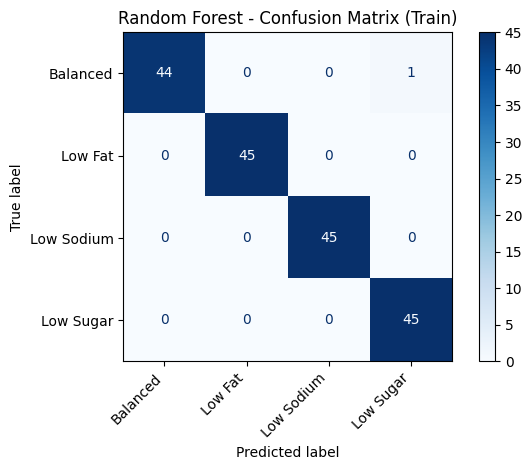


Validation Accuracy: 0.94
              precision    recall  f1-score   support

    Balanced       1.00      1.00      1.00        10
     Low Fat       0.88      0.88      0.88         8
  Low Sodium       1.00      1.00      1.00         8
   Low Sugar       0.89      0.89      0.89         9

    accuracy                           0.94        35
   macro avg       0.94      0.94      0.94        35
weighted avg       0.94      0.94      0.94        35



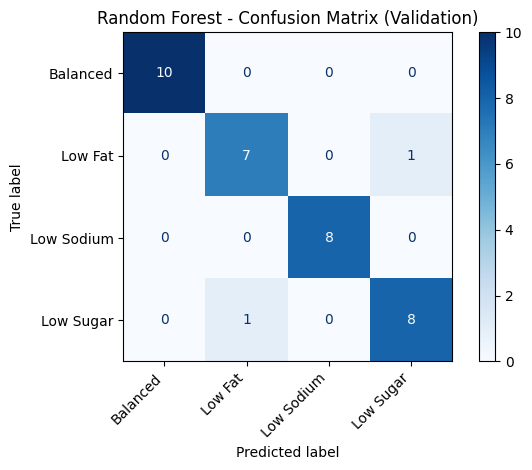


Test Accuracy: 0.94
              precision    recall  f1-score   support

    Balanced       1.00      1.00      1.00        10
     Low Fat       0.80      1.00      0.89         8
  Low Sodium       1.00      1.00      1.00         8
   Low Sugar       1.00      0.78      0.88         9

    accuracy                           0.94        35
   macro avg       0.95      0.94      0.94        35
weighted avg       0.95      0.94      0.94        35



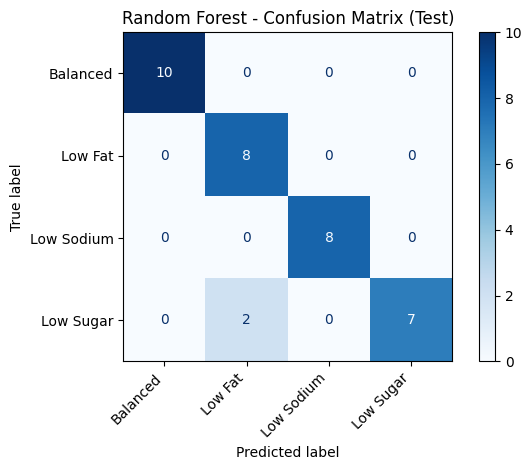

Cross-Validated Accuracy (Random Forest): Mean = 0.974, Std = 0.021


C:\Users\User\AppData\Local\Temp\ipykernel_2960\747727505.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(X.columns)[indices], palette='crest')


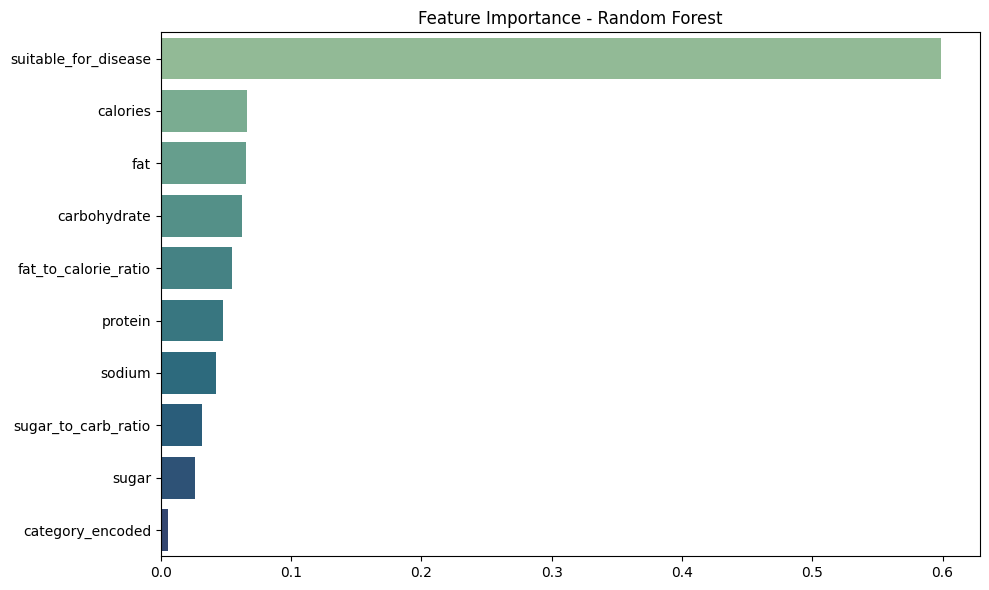

c:\xampp\htdocs\Food\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\xampp\htdocs\Food\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\xampp\htdocs\Food\.venv\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\xampp\htdocs\Food\.venv\Lib\site-packages\imblearn\pipeline.py", line 518, in fit
    Xt, yt = self._fit

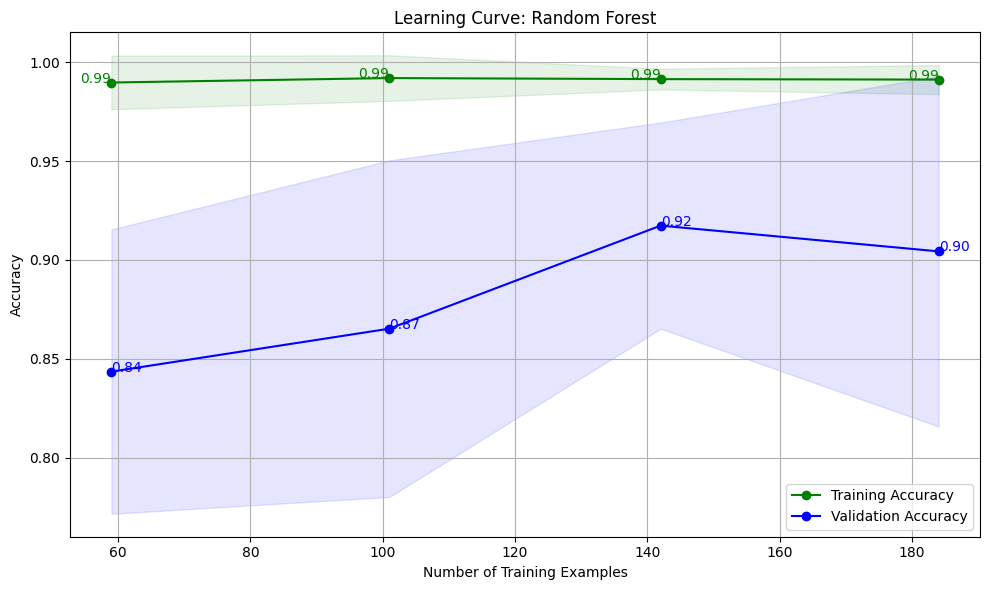

✅ โมเดลและ label encoder ถูกบันทึกเรียบร้อยแล้ว
✅ บันทึกโมเดลและ encoders เรียบร้อยแล้ว


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# --- 1. Load Data ---
df = pd.read_csv('Food-Menu - food_menu.csv')

# --- 2. Translate food_type labels ---
translate_labels = {
    'สมดุล': 'Balanced',
    'ไขมันต่ำ': 'Low Fat',
    'น้ำตาลต่ำ': 'Low Sugar',
    'โซเดียมต่ำ': 'Low Sodium'
}
df['food_type'] = df['food_type'].map(translate_labels)

# --- 3. Feature Engineering ---
df['category_encoded'] = LabelEncoder().fit_transform(df['category'])
df['suitable_for_disease'] = LabelEncoder().fit_transform(df['suitable_for_disease'])
df['sugar_to_carb_ratio'] = df['sugar'] / (df['carbohydrate'] + 1e-8)
df['fat_to_calorie_ratio'] = df['fat'] / (df['calories'] + 1e-8)

# --- 4. Feature/Target Selection ---
X = df[['calories', 'protein', 'carbohydrate', 'sugar', 'fat', 'sodium',
        'category_encoded', 'suitable_for_disease', 'sugar_to_carb_ratio', 'fat_to_calorie_ratio']]
y = df['food_type']
print(X.dtypes)

le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_labels = le.classes_
print(list(enumerate(class_labels)))

# --- 5. Split Train/Val/Test ---
X_temp, X_test, y_temp, y_test = train_test_split(X, y_encoded, test_size=0.15, stratify=y_encoded, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, stratify=y_temp, random_state=42)

# --- 6. Preprocessing ---
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

X_train = scaler.fit_transform(imputer.fit_transform(X_train))
X_val = scaler.transform(imputer.transform(X_val))
X_test = scaler.transform(imputer.transform(X_test))

# --- 7. SMOTE ---
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# --- 8. Model ---
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=5,
    random_state=42,
    class_weight='balanced'
)

# --- 9. Train & Evaluate ---
print("\n--- Training Random Forest ---")
model.fit(X_train_balanced, y_train_balanced)

# Train eval
y_pred_train = model.predict(X_train_balanced)
acc_train = accuracy_score(y_train_balanced, y_pred_train)
print(f"\nTrain Accuracy: {acc_train:.2f}")
print(classification_report(y_train_balanced, y_pred_train, target_names=class_labels))
ConfusionMatrixDisplay.from_predictions(y_train_balanced, y_pred_train, display_labels=class_labels, cmap='Blues')
plt.title("Random Forest - Confusion Matrix (Train)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Validation eval
y_pred_val = model.predict(X_val)
acc_val = accuracy_score(y_val, y_pred_val)
print(f"\nValidation Accuracy: {acc_val:.2f}")
print(classification_report(y_val, y_pred_val, target_names=class_labels))
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val, display_labels=class_labels, cmap='Blues')
plt.title("Random Forest - Confusion Matrix (Validation)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Test eval
y_pred_test = model.predict(X_test)
acc_test = accuracy_score(y_test, y_pred_test)
print(f"\nTest Accuracy: {acc_test:.2f}")
print(classification_report(y_test, y_pred_test, target_names=class_labels))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=class_labels, cmap='Blues')
plt.title("Random Forest - Confusion Matrix (Test)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- 11. Cross Validation ---
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', model)
])
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X, y_encoded, cv=kfold, scoring='accuracy')
print(f"Cross-Validated Accuracy (Random Forest): Mean = {scores.mean():.3f}, Std = {scores.std():.3f}")

# --- 12. Feature Importance ---
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices], y=np.array(X.columns)[indices], palette='crest')
    plt.title("Feature Importance - Random Forest")
    plt.tight_layout()
    plt.show()

# --- 13. Learning Curve ---
def plot_learning_curve(model, model_name, X, y, cv, scoring='accuracy'):
    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

    train_sizes, train_scores, val_scores = learning_curve(
        estimator=pipe,
        X=X,
        y=y,
        train_sizes=np.linspace(0.1, 1.0, 5),
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        shuffle=True,
        random_state=42
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='green', label='Training Accuracy')
    plt.plot(train_sizes, val_mean, 'o-', color='blue', label='Validation Accuracy')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='green')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='blue')
    for i in range(len(train_sizes)):
        plt.text(train_sizes[i], train_mean[i], f"{train_mean[i]:.2f}", color='green', ha='right')
        plt.text(train_sizes[i], val_mean[i], f"{val_mean[i]:.2f}", color='blue', ha='left')
    plt.title(f'Learning Curve: {model_name}')
    plt.xlabel('Number of Training Examples')
    plt.ylabel(scoring.capitalize())
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_learning_curve(model, "Random Forest", X, y_encoded, cv=5)


import joblib
from sklearn.preprocessing import LabelEncoder

# สำหรับ category
category_encoder = LabelEncoder()
df['category_encoded'] = category_encoder.fit_transform(df['category'])

# สำหรับ suitable_for_disease
disease_encoder = LabelEncoder()
df['suitable_for_disease'] = disease_encoder.fit_transform(df['suitable_for_disease'])


# บันทึกโมเดลและ encoders
import joblib

# --- 14. Save Model and Label Encoder ---
joblib.dump(model, 'random_forest_model.pkl')               # บันทึกตัวโมเดล
joblib.dump(le, 'label_encoder.pkl')                        # บันทึก LabelEncoder ของ target
print("✅ โมเดลและ label encoder ถูกบันทึกเรียบร้อยแล้ว")


print("✅ บันทึกโมเดลและ encoders เรียบร้อยแล้ว")

